# Modelo

Lo primero que vamos a hacer es describir los modelos DEVS utilizados para poder realizar la simulación.

## Sol
Modelo atómico que actúa como generador y emite radiación con cierto ángulo. En particular, éste modelo tiene únicamente 2 puertos de salida: *radiation* y *degree*, que estan conectados a los puertos de entrada del panel solar, como será descrito a continuación.

## Motor
Modelo atómico contenido por el panel solar. Recibe un parámetro, *consumption_factor*. Su único puerto de entrada es *rotation*, y cada vez que recibe un valor por este puerto, en base al *consumption_factor*, emite por su puerto de salida la *consumed_energy*, cuyo valor es redirigido a los puertos de entrada con el mismo nombre del modelo Panel Solar --para mandar al top-- y Controlador --para actualizar la batería--.

## Celda solar
Modelo atómico contenido por el panel solar. Recibe un parámetro, *conversion_factor*. Su único puerto de entrada es *received_energy*, cuyos valores provienen del panel solar y, en base al parámetro, va a absorver una cantidad de energía y la va a emitir por su puerto de salida *obtained_energy*, cuyo destino final será el Controlador --para actualizar la batería-- y el panel solar --para mandar al top--.

<img src="./diagrama.png">

In [2]:
# %load_ext autoreload
# %autoreload 2

import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from util_analysis import *

Primero parseamos los datos que obtenemos del output para que sea más cómodo

In [3]:
df = fetch_sim_data('vtol-')

Processing file vtol-tol-5
Processing file vtol-tol-3
Processing file vtol-tol-15
Processing file vtol-tol-0.5
Processing file vtol-tol-25
Processing file vtol-tol-1
Processing file vtol-tol-20
Processing file vtol-tol-10


Primero mostramos el comportamiento del sol el comportamiento del sol

In [4]:
df['sun_degree'] = df['sun_degree'].apply(lambda x: float(x))
df['sun_radiation'] = df['sun_radiation'].apply(lambda x: float(x))

Radiación: 6.17


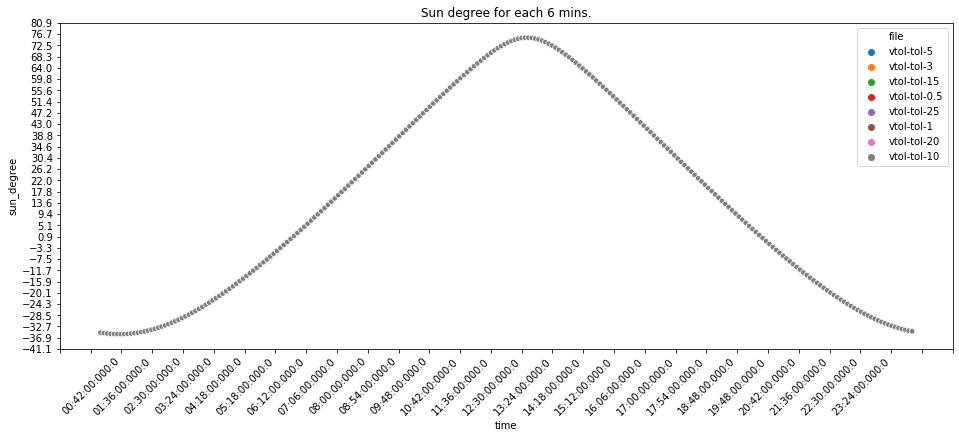

In [5]:
# plt.figure(figsize=(16, 6))
# ax1 = sns.scatterplot(x='time', y='sun_radiation',data=df, hue='file', s=30)
# ax1.xaxis.set_major_locator(ticker.LinearLocator(30))
# plt.xticks(rotation=45, ha='right')
# plt.title("Sun radiation for each 6 mins.")
# plt.show()

print('Radiación: ' + str(df['sun_radiation'].iloc[-1]))

plt.figure(figsize=(16, 6))
ax2 = sns.scatterplot(x='time', y='sun_degree',data=df, hue='file', s=30)
ax2.xaxis.set_major_locator(ticker.LinearLocator(30))
ax2.yaxis.set_major_locator(ticker.LinearLocator(30))
plt.xticks(rotation=45, ha='right')
plt.title("Sun degree for each 6 mins.")
plt.show()

Aqui se puede ver como se modifica el angulo de elevacion del sol respecto al piso. Ahora veremos la energía neta obtenida. Para ello, agregamos una columna con las energía neta obtenida en cada instante

In [6]:
obtained_energies =df['obtained_energy'].apply(lambda x: float(x))
consumed_energies = df['consumed_energy'].apply(lambda x: float(x))
df['net_obtained_energy'] = obtained_energies - consumed_energies

In [7]:
def valor_de_param(y):
    return float(y.split('-')[-1])


files_ordenados = sorted(df['file'].unique(), key=valor_de_param)

A continuacion seleccionamos distintas tolerancias muy variadas con el resto de los parámetros fijos y miramos la energía neta obtenida en cada instante durante 1 día.

Los valores previos a las 6hs y posteriores a las 20hs fueron omitidos dado que son nulos.

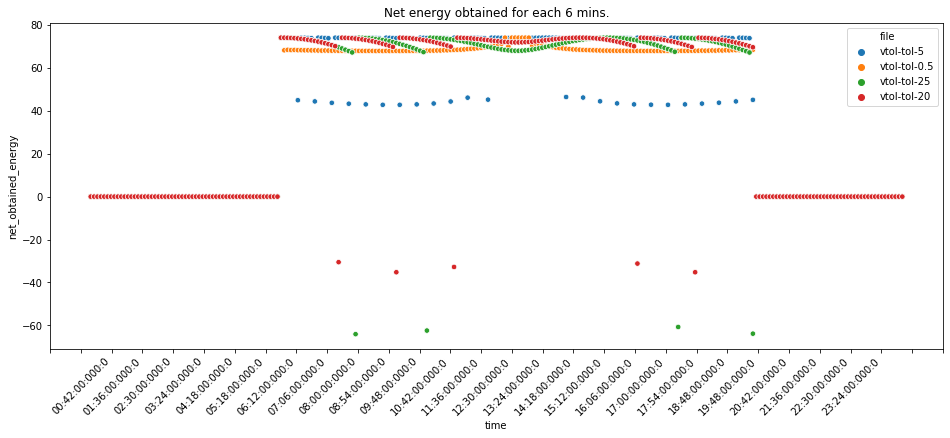

In [8]:
plt.figure(figsize=(16, 6))

selected_files = ['vtol-tol-0.5', 'vtol-tol-5', 'vtol-tol-20', 'vtol-tol-25']
df2 = df[df['file'].isin(selected_files)]
ax3 = sns.scatterplot(x='time', y='net_obtained_energy',data=df2, hue='file', s=30)
ax3.xaxis.set_major_locator(ticker.LinearLocator(30))
#plt.ylim(bottom=50)
plt.xticks(rotation=45, ha='right')
plt.title("Net energy obtained for each 6 mins.")
plt.show()

Lo que puede verse  es que partiendo con una tolerancia baja, la ganancia en cada instante es menor pero se mantiene en el tiempo. Por el contrario, con las otras tolerancias se ve como empieza con una ganancia alta y va decreciendo (cuando el sol empieza a alejarse con respecto al ángulo del panel) hasta que eventualmente se supera el umbral de tolerancia efectuando el movimiento y así volviendo a obtener mucha energía. es importante ver que a menor tolerancia, el momento del movimiento, al ser mas corto y mas frecuente, el consumo de energia instantanea es mas bajo, se puede ver en los puntos celestes por ejemplo, donde baja el rendimiento pero no demasiado y con las tolerancias de 20 y 25 el consumo es mucho mayor a lo generado y se da una perdida en ese instante, este golpe de consumo puede afectar al sistema asique es un comportamiento a ser tomado en cuenta.

En el siguiente grafico vamos a "hacer zoom" en la zona superior que en este caso no se puede apreciar bien que es lo que esta sucediendo:


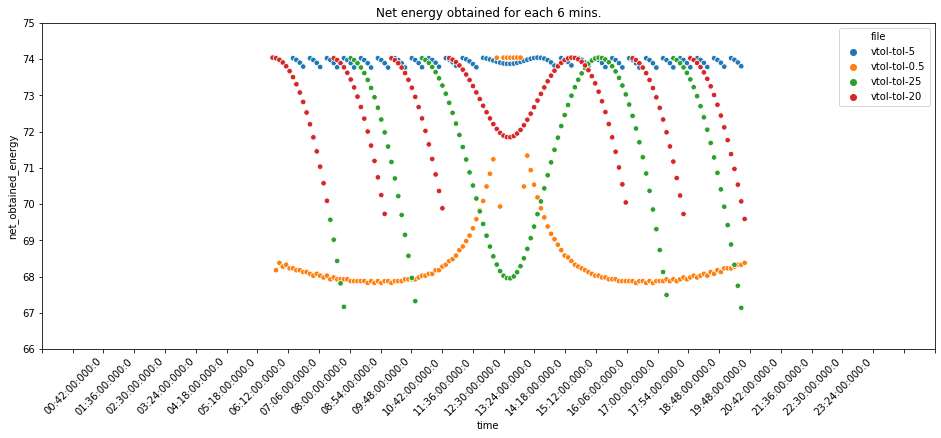

In [11]:
plt.figure(figsize=(16, 6))

selected_files = ['vtol-tol-0.5', 'vtol-tol-5', 'vtol-tol-20', 'vtol-tol-25']
df2 = df[df['file'].isin(selected_files)]
ax3 = sns.scatterplot(x='time', y='net_obtained_energy',data=df2, hue='file', s=30)
ax3.xaxis.set_major_locator(ticker.LinearLocator(30))
plt.ylim(bottom=66, top=75)
plt.xticks(rotation=45, ha='right')
plt.title("Net energy obtained for each 6 mins.")
plt.show()

En esta parte superior de los resultados se puede ver como generan los paneles a lo largo del dia, el amarillo, con una tolerancia muy chica, esta constantemente ajustandose entonces a cada paso consume un poco y genera relativamente mucho y se manntiene en la curva que se ve, salvo al mediodia que no se tiene que mover y genera a su maximo potencial.

Luego entre los de tolerancia 5, 20 y 25 se puede ver un patron, comienzan generando bien, pierden eficiencia con el tiempo y luego reajustan y recomienzan el ciclo, se puede ver que el de 5 es el mas estable en general, se mantiene con valores superiores con los reajustes que vimos en el grafico anterior. Cabe destacar que ambos de 20 y 25 tienen una muy mala generacion en el pico de radiacion del dia que es el mediodia.


Tambien nos interesa saber el rendimiento al finalizar el día, por lo cual en el próximo experimento vamos a analizar las energías capturadas por las baterías correspondientes a cada simulación, pero ahora considerando más tolerancias posibles para ver cuál conviene tomar para éste día y parámetros fijados en particular.

Tomamos entonces el último valor de la batería en cada simulación, que nos dice cuanta energía neta se acumuló en total:


In [12]:
batteries = df.groupby('file')['battery'].last().reset_index()
batteries['battery'] = batteries['battery'].apply(lambda x: float(x))
batteries

,file,battery
0,vtol-tol-0.5,9616.04682
1,vtol-tol-1,9613.32435
2,vtol-tol-10,9551.24120
3,vtol-tol-15,9605.49376
4,vtol-tol-20,9642.02795
5,vtol-tol-25,9469.69169
6,vtol-tol-3,9623.34624
7,vtol-tol-5,9630.43818


Text(0.5, 1.0, 'Total net energy obtained by the end of the day')

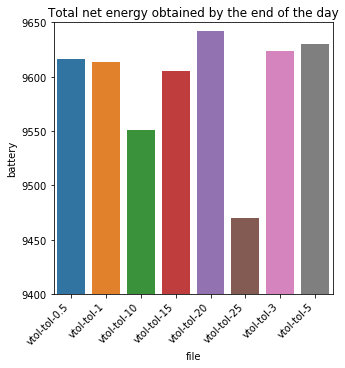

In [13]:
plt.figure(figsize=(5, 5))

ax4 = sns.barplot(x=batteries['file'], y='battery', data=batteries)
plt.xticks(rotation=45, ha='right')
plt.ylim(bottom=9400, top=9650)
plt.title("Total net energy obtained by the end of the day")

Lo que parece verse hasta ahora es que conviene utilizar tolerancias altas, pero no demasiado. Veamos que pasa cuando experimentamos con distintos factores de consumo en el motor.

In [14]:
df_vtol = df
df = fetch_sim_data('vtolcons')

Processing file vtolcons-tol-cons-5-1
Processing file vtolcons-tol-cons-20-20
Processing file vtolcons-tol-cons-1-1
Processing file vtolcons-tol-cons-20-1
Processing file vtolcons-tol-cons-5-20
Processing file vtolcons-tol-cons-1-20


In [15]:
print('Radiación: ' + str(df['sun_radiation'].iloc[-1]))

Radiación: 6.17000


In [16]:
obtained_energies =df['obtained_energy'].apply(lambda x: float(x))
consumed_energies = df['consumed_energy'].apply(lambda x: float(x))
df['net_obtained_energy'] = obtained_energies - consumed_energies

In [17]:
def valor_de_param(y):
    return float(y.split('-')[-1])


files_ordenados = sorted(df['file'].unique(), key=valor_de_param)

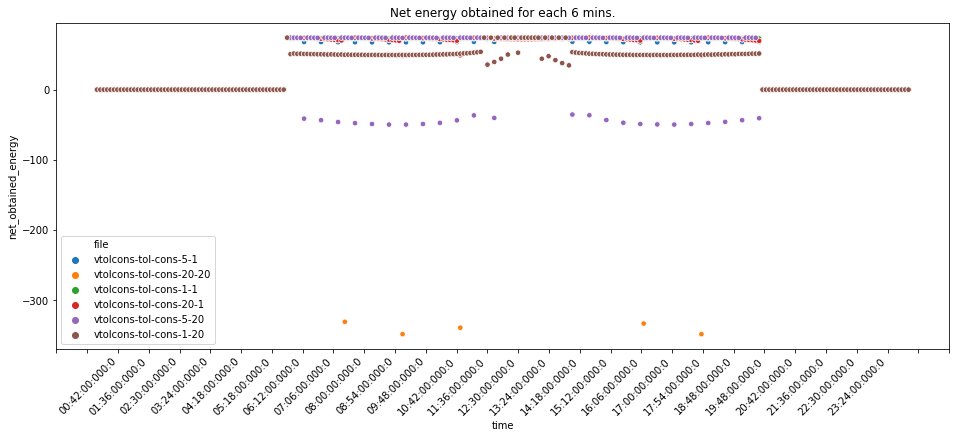

In [18]:
plt.figure(figsize=(16, 6))

selected_files = ['vtolcons-tol-cons-5-1','vtolcons-tol-cons-5-20','vtolcons-tol-cons-1-1', 'vtolcons-tol-cons-20-1', 'vtolcons-tol-cons-1-20', 'vtolcons-tol-cons-20-20'] 
df2 = df[df['file'].isin(selected_files)]
ax3 = sns.scatterplot(x='time', y='net_obtained_energy',data=df2, hue='file', s=30)
ax3.xaxis.set_major_locator(ticker.LinearLocator(30))

plt.xticks(rotation=45, ha='right')
plt.title("Net energy obtained for each 6 mins.")
plt.show()



Globalmente podemos ver que de nuevo los de muy baja tolerancia se mantienen en un lugar estable cerca del tope pero no arriba de todo, salvo al mediodia, y que los de grandes tolerancias se comportan igual que antes pero se ve que los que tiene mayores consumos tienen saltos muy grandes de consumo cuando deben moverse.
veamos mas de cerca:

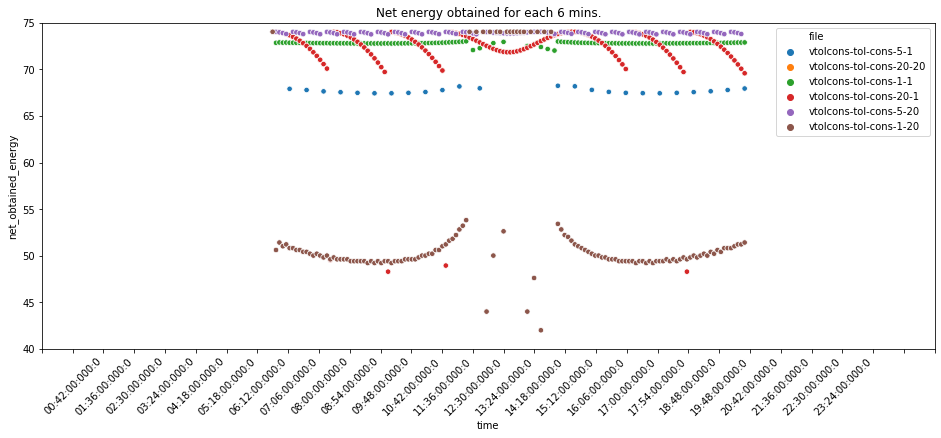

In [19]:
plt.figure(figsize=(16, 6))

selected_files = ['vtolcons-tol-cons-5-1','vtolcons-tol-cons-5-20','vtolcons-tol-cons-1-1', 'vtolcons-tol-cons-20-1', 'vtolcons-tol-cons-1-20', 'vtolcons-tol-cons-20-20'] 
df2 = df[df['file'].isin(selected_files)]
ax3 = sns.scatterplot(x='time', y='net_obtained_energy',data=df2, hue='file', s=30)
ax3.xaxis.set_major_locator(ticker.LinearLocator(30))
plt.ylim(bottom= 40,top=75)

plt.xticks(rotation=45, ha='right')
plt.title("Net energy obtained for each 6 mins.")
plt.show()

Aqui apreciamos como el que tiene poca tolerancia pero mucho consumo se comporta igual que antes pero muy por debajo del resto dado el gran consumo que hace cada vez que se mueve, salvo claro, al mediodia.
Luego el de tolerancia intermedia pero de bajo consumo se ve en la forma de los puntos celeste, veamos aun mas cerca:

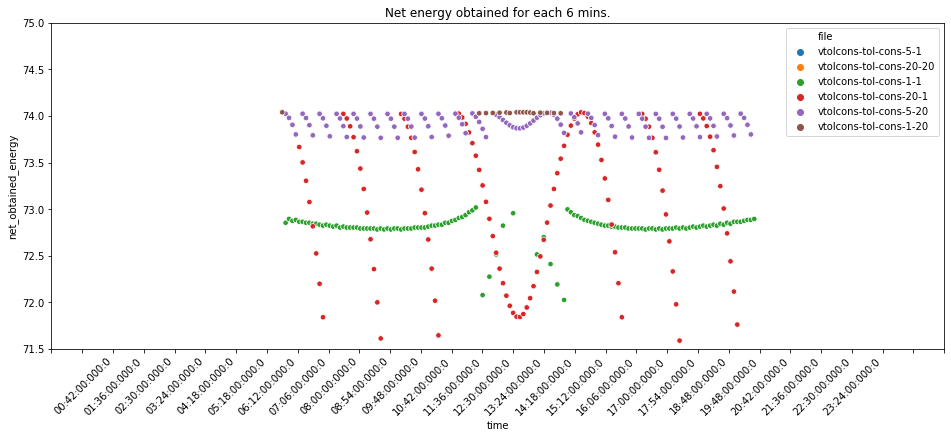

In [21]:
plt.figure(figsize=(16, 6))

selected_files = ['vtolcons-tol-cons-5-1','vtolcons-tol-cons-5-20','vtolcons-tol-cons-1-1', 'vtolcons-tol-cons-20-1', 'vtolcons-tol-cons-1-20', 'vtolcons-tol-cons-20-20'] 
df2 = df[df['file'].isin(selected_files)]
ax3 = sns.scatterplot(x='time', y='net_obtained_energy',data=df2, hue='file', s=30)
ax3.xaxis.set_major_locator(ticker.LinearLocator(30))
plt.ylim(bottom= 71.5,top=75)

plt.xticks(rotation=45, ha='right')
plt.title("Net energy obtained for each 6 mins.")
plt.show()

aqui vemos como se comportan todos cuando no se mueven, por ejemplo lo rojo representa al rojo y al amarillo, pues ambos tienen la misma tolerancia asique van a moverse al mismo tiempo, y lo mismo para el azul y el violeta, representados por este ultimo, todos similares a lo visto antes.
Fialmente esta el verde que es el que tiene baja tolerancia y bajo consumo, que se comporta similar a su contraparte de alto consumo pero mas cerca de los valores optimos de generacion.
Ahora miremos los resultados finales:

In [22]:
batteries = df.groupby('file')['battery'].last().reset_index()
batteries['battery'] = batteries['battery'].apply(lambda x: float(x))
batteries

,file,battery
0,vtolcons-tol-cons-1-1,10213.40439
1,vtolcons-tol-cons-1-20,7363.02420
2,vtolcons-tol-cons-20-1,10051.42793
3,vtolcons-tol-cons-20-20,8106.77796
4,vtolcons-tol-cons-5-1,10200.35822
5,vtolcons-tol-cons-5-20,7493.23801


para los casos en los que los consumos son bajos, la generacion mas eficiente se da para tolerancias muy bajas, como se ve en el 1-1, pero para casos en los que los consumos son muy altos, conviene moverse menos frecuentemente como se puede ver por el resultado final de 20-20 que genero mas que 5-20 y 1-20. pero denuevo tenemos la problematica de los golpes de consumo que para este caso son aun mas drasticos.
Ahora damos un pequeño grafico de barras de estos mismos valores

Text(0.5, 1.0, 'Total net energy obtained by the end of the day')

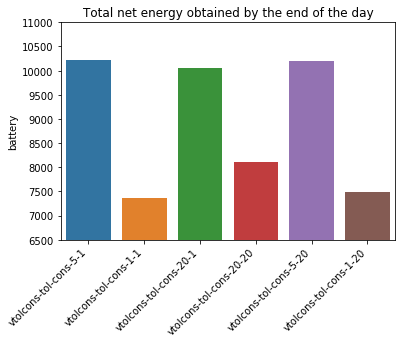

In [25]:
# plt.figure(figsize=(5, 5))

ax4 = sns.barplot(x=files_ordenados, y='battery', data=batteries)
plt.xticks(rotation=45, ha='right')
plt.ylim(bottom=6500, top=11000)
plt.title("Total net energy obtained by the end of the day")

In [29]:
df_vtolcons = df
df = fetch_sim_data('vexttol')

Processing file vexttol-tol-3
Processing file vexttol-tol-6
Processing file vexttol-tol-1
Processing file vexttol-tol-10


,time,file,sun_radiation,sun_degree,obtained_energy,consumed_energy,battery
0,00:06:00:000:0,vexttol-tol-3,9.14000,-35.01000,0.00000,0.00000,0.00000
1,00:12:00:000:0,vexttol-tol-3,9.14000,-35.19000,0.00000,0.00000,0.00000
2,00:18:00:000:0,vexttol-tol-3,9.14000,-35.34000,0.00000,0.00000,0.00000
3,00:24:00:000:0,vexttol-tol-3,9.14000,-35.46000,0.00000,0.00000,0.00000
4,00:30:00:000:0,vexttol-tol-3,9.14000,-35.53000,0.00000,0.00000,0.00000
5,00:36:00:000:0,vexttol-tol-3,9.14000,-35.57000,0.00000,0.00000,0.00000
6,00:42:00:000:0,vexttol-tol-3,9.14000,-35.58000,0.00000,0.00000,0.00000
7,00:48:00:000:0,vexttol-tol-3,9.14000,-35.54000,0.00000,0.00000,0.00000
8,00:54:00:000:0,vexttol-tol-3,9.14000,-35.47000,0.00000,0.00000,0.00000
9,01:00:00:000:0,vexttol-tol-3,9.14000,-35.36000,0.00000,0.00000,0.00000


In [30]:
df['sun_degree'] = df['sun_degree'].apply(lambda x: float(x))
df['sun_radiation'] = df['sun_radiation'].apply(lambda x: float(x))

In [55]:
rad = pd.read_csv("../src/CSV_Seasonal_radiation_show.csv")

Text(0.5, 1.0, 'Total Radiaton for each day')

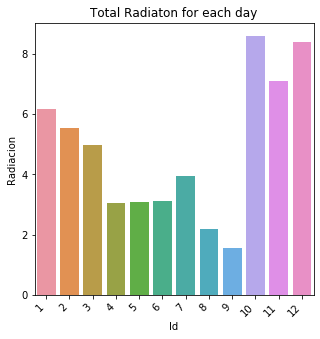

In [58]:
plt.figure(figsize=(5, 5))
ax10 = sns.barplot(x='Id', y='Radiacion', data=rad)
plt.xticks(rotation=45, ha='right')
#plt.ylim(bottom=6500, top=11000)
plt.title("Total Radiaton for each day")

aqui vemos las radiaciones que emite el sol para diversos dias del año, se tomaron 3 dias de cada momento de cambio de estasciones (entre estos dias estan el mas corto y el mas largo del año), son 12 dias en total y la idea es que esto sea una muestra significativa.

In [57]:
#plt.figure(figsize=(16, 6))
#ax1 = sns.scatterplot(x='time', y='sun_radiation',data=df, hue='file', s=30)
#ax1.xaxis.set_major_locator(ticker.LinearLocator(30))
#plt.xticks(rotation=45, ha='right')
#plt.title("Sun radiation.")
#plt.show()

In [59]:
obtained_energies =df['obtained_energy'].apply(lambda x: float(x))
consumed_energies = df['consumed_energy'].apply(lambda x: float(x))
df['net_obtained_energy'] = obtained_energies - consumed_energies

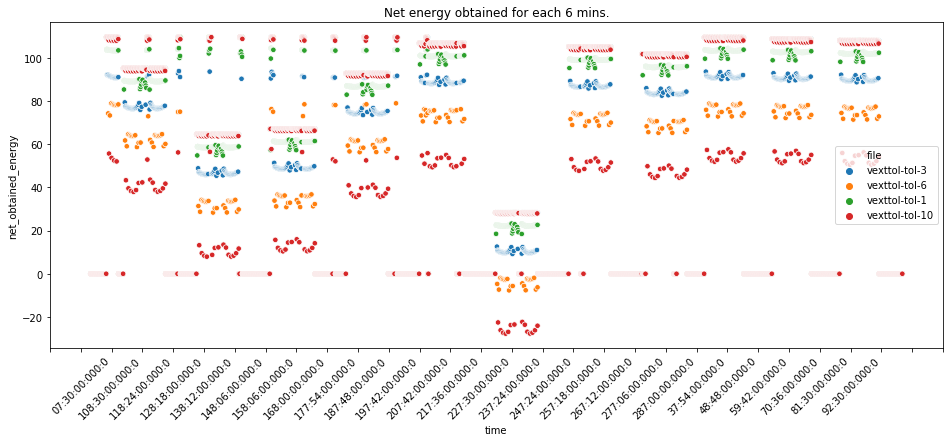

In [60]:
plt.figure(figsize=(16, 6))

ax3 = sns.scatterplot(x='time', y='net_obtained_energy',data=df, hue='file', s=30)
ax3.xaxis.set_major_locator(ticker.LinearLocator(30))
# plt.ylim(bottom=50)
plt.xticks(rotation=45, ha='right')
plt.title("Net energy obtained for each 6 mins.")
plt.show()

En este grafico vemos como se comporta cada sistema con diferentes tolerancias, para los distintos dias que vimos antes, si se presta atencion podremos ver que cada dia se es un grafico similar a los vistos antes, pero 12 veces.
Lo notable es que los que tienen tolerancias muy altas, en los dias de muy poca radiacion, generan muchas perdidas y eso puede ser un problema si se da una epoca prolongada de poco sol, podria dejar el sistema inutilizable.
No es facil ver mucho mas con este grafico, pero podremos decir cosas mas interesantes si observamos la generacion neta final de todo el experimento para cada caso:


In [61]:
batteries = df.groupby('file')['battery'].last().reset_index()
batteries['battery'] = batteries['battery'].apply(lambda x: float(x))
batteries

,file,battery
0,vexttol-tol-1,58059.78260
1,vexttol-tol-10,57691.09100
2,vexttol-tol-3,58134.22395
3,vexttol-tol-6,58067.65111


Aqui podemos ver que finalmente, dadas todas las condiciones, la mejor tolerancia de angulo del sol para generar energia es baja, pero no demasiado baja, en este caso 3 grados de tolerancia fue lo mas eficiente, pero igualmente las diferencias no son tan grandes, asique hay mucho lugar para poder seguir experimentando con mayor precision para poder tener mas informacion sobre que conviene decidir en cada situacion.

Text(0.5, 1.0, 'Total net energy obtained by the end of the day')

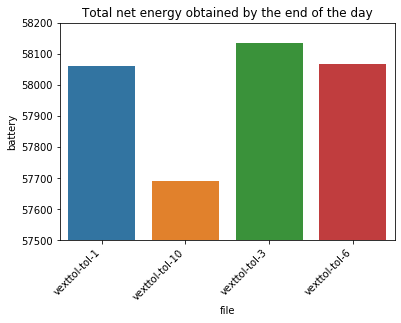

In [63]:
# plt.figure(figsize=(5, 5))

ax4 = sns.barplot(x='file', y='battery', data=batteries)
plt.xticks(rotation=45, ha='right')
plt.ylim(bottom=57500, top=58200)
plt.title("Total net energy obtained by the end of the day")

Finalmente, podemos decir que el trabajo deja algunas conclusiones interesantes, pero aun hay mucho lugar a experimentacion como por ejemplo ser mayor cantidad de dias, cambiar los angulos del sol segun la temporada, simular movimiento en ambos planos y no uno solo, simular con distintos rendimientos de panel, areas de panel, varios paneles, condiciones particulares de clima (lluvia, nubes, polvo en los paneles)